In [114]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as sparse_linalg

#### 跳水板没有负载时，及 $f(x)=-480wdg$ 为常数时，有
$$
\begin{aligned}
EIy''''&=f(x)=f \\
y'''&=\frac{f}{EI}x+C_1 \\
y''&=\frac{f}{2EI}x^2+C_1x+C_2 \\
y'&=\frac{f}{6EI}x^3+\frac{C_1}{2}x^2+C_2x+C_3 \\
y&=\frac{f}{24EI}x^4+\frac{C_1}{6}x^3+\frac{C_2}{2}x^2+C_3x+C_4 \\ \\
Because \; y(0)=y'(0)&=y''(L)=y'''(L)=0\\
C_4=C_3&=0 \\
C_1&=-\frac{fL}{EI} \\
C_2&=-\frac{fL^2}{2EI}-C_1L=\frac{fL^2}{2EI} \\ \\
Then \\
y&=\frac{f}{24EI}x^4-\frac{fL}{6EI}x^3+\frac{fL^2}{4EI}x^2 \\
 &=\frac{f}{24EI}x^2(x^2-4Lx+6L^2)
\end{aligned}
$$

In [33]:
# 检查单位匹配
Length = 2 # meter
w = 0.3 # meter
d = 0.03 # meter
E = 1.3e+10 #pascal or N/m^2
I = w*d**3/12
rho = 480 # kg/m^3
f = -rho*w*d*9.81
y = lambda x: f/(24*E*I)*x**2*(x**2-4*Length*x+6*Length**2)
# 计算末端的偏移
print(y(2))

-0.009659076923076925


In [58]:
# 9毫米偏移，看起来单位没什么问题。

In [107]:
def MakeA(n: int, printOrNot=False, sparseOrNot=False):
    if n < 5:
        print("n is too small.")
        return None

    if sparseOrNot:
        A = sparse.lil_matrix((n, n))
    else:
        A = np.zeros(n*n).reshape(n, n)

    A[0, :4] = [16., -9., 8/3, -0.25]
    A[1, :4] = [-4.,  6., -4.,    1.]
    A[-2, -4:] = [ 16/17, -60/17, 72/17, -28/17]
    A[-1, -4:] = [-12/17, 96/17, -156/17, 72/17]
    for row in range(2, n-2):
        A[row, row-2:row+3] = [1., -4., 6., -4., 1.]
    
    if printOrNot:
        if not sparseOrNot:
            np.set_printoptions(precision=5, linewidth=120)
        print('A:\n', A)
    return A

def PA_LU_Factorization(A_, printOrNot=False, check=False):
    order = A_.shape[0]

    # Upper triangular matrix
    U = A_.copy()
    # Lower triangular matrix
    L = np.eye(order)
    # Permutation matrix
    P = np.eye(order)
    if type(A_) is sparse._lil.lil_matrix:
        L = sparse.lil_matrix(L)
        P = sparse.lil_matrix(P)

    # Elimination
    for col in range(order):
        # A matrix with pivot equals to 0 would be SINGULAR.
        if np.abs(A_[col, col]) < 0.00000001:
            print("Zero pivot encounterd. i=j=:", col)
            return None
        
        # Let pivot be the max element in the column.
        rowToSwap = np.argmax(U[col:, col])+col
        if rowToSwap != col:
            U[[col, rowToSwap], :] = U[[rowToSwap, col], :]
            P[[col, rowToSwap], :] = P[[rowToSwap, col], :]

        for row in range(col+1, order):
            mult = U[row, col]/U[col, col]
            U[row, col] = mult
            for k in range(col+1, order):
                U[row, k] -= mult*U[col, k]
    
    # Set L and clear U
    for row in range(1, order):
        for col in range(row):
            L[row, col] = U[row, col]
            U[row, col] = 0.

    if printOrNot:
        print('P:\n', P)
        print('L:\n', L)
        print('U:\n', U)

    if check:
        print('error:\n', np.abs(A_-np.linalg.inv(P)@L@U))

    return (P, L, U)

def TwoStepBackSubstitution(P, L, U, b_, printOrNot=False, check=False):
    b = b_.copy()
    order = P.shape[0]

    # PAx=Pb
    # LUx=Pb
    # Let Lc=Pb, then evaluate c
    # Let Ux=c, then evaluate x

    # Solve Lc=Pb
    b = P@b
    c = np.zeros(order)
    for row in range(order):
        for col in range(row):
            b[row] -= L[row, col]*c[col]
        c[row] = b[row]

    # Solve Ux=c
    x = np.zeros(order)
    for row in range(order)[::-1]:
        for col in range(row+1, order):
            c[row] -= U[row, col]*x[col]
        x[row] = c[row]/U[row, row]
    
    if printOrNot:
        print('x:\n', x)

    if check:
        print('error: ', np.abs(P@b_-L@U@x))
    return x

# Example 2.16
testM = np.array([[2.,1,5], [4,4,-4], [1,3,1]])
P, L, U = PA_LU_Factorization(testM, True, True)
y = TwoStepBackSubstitution(P, L, U, np.array([5.,0,6]), True, True)

# Sparse matrix test
n = 10
A = MakeA(n, sparseOrNot=True)
P,L,U = PA_LU_Factorization(A, printOrNot=True)
b = np.ones(n)*(f*(Length/n)**4/E/I)
y = TwoStepBackSubstitution(P, L, U, b, printOrNot=True)

P:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
L:
 [[ 1.    0.    0.  ]
 [ 0.25  1.    0.  ]
 [ 0.5  -0.5   1.  ]]
U:
 [[ 4.  4. -4.]
 [ 0.  2.  2.]
 [ 0.  0.  8.]]
error:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
x:
 [-1.  2.  1.]
error:  [0. 0. 0.]
P:
   (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
L:
   (0, 0)	1.0
  (1, 0)	-0.25
  (1, 1)	1.0
  (2, 0)	0.0625
  (2, 1)	-0.9166666666666666
  (2, 2)	1.0
  (3, 1)	0.26666666666666666
  (3, 2)	-1.12
  (3, 3)	1.0
  (4, 2)	0.36
  (4, 3)	-1.2777777777777781
  (4, 4)	1.0
  (5, 3)	0.44444444444444453
  (5, 4)	-1.3877551020408172
  (5, 5)	1.0
  (6, 4)	0.5102040816326534
  (6, 5)	-1.4687500000000016
  (6, 6)	1.0
  (7, 5)	0.5625000000000008
  (7, 6)	-1.5308641975308663
  (7, 7)	1.0
  (8, 6)	0.5693536673928842
  (8, 7)	-1.3364705882352959
  (8, 8)	1.0
  (9, 6)	-0.42701525054466316
  (9, 7)	2.9223529411764764
  (9, 8)	-4.190476190476192
  (9, 9)	1.0
U:
   (0, 0)	16.0
  (0, 1)	-9

1. 写出定义(2.34)中结构矩阵A的MATLAB程序。然后，使用MATLAB的\命令或者自己设计的代码，求解系统，得到偏移 $y_i$，使用$n=10$作为网格大小.


In [108]:
n = 10
A = MakeA(n, True)
b = np.ones(n)*(f*(Length/n)**4/E/I)
P,L,U = PA_LU_Factorization(A)
y = TwoStepBackSubstitution(P, L, U, b, True)

A:
 [[16.      -9.       2.66667 -0.25     0.       0.       0.       0.       0.       0.     ]
 [-4.       6.      -4.       1.       0.       0.       0.       0.       0.       0.     ]
 [ 1.      -4.       6.      -4.       1.       0.       0.       0.       0.       0.     ]
 [ 0.       1.      -4.       6.      -4.       1.       0.       0.       0.       0.     ]
 [ 0.       0.       1.      -4.       6.      -4.       1.       0.       0.       0.     ]
 [ 0.       0.       0.       1.      -4.       6.      -4.       1.       0.       0.     ]
 [ 0.       0.       0.       0.       1.      -4.       6.      -4.       1.       0.     ]
 [ 0.       0.       0.       0.       0.       1.      -4.       6.      -4.       1.     ]
 [ 0.       0.       0.       0.       0.       0.       0.94118 -3.52941  4.23529 -1.64706]
 [ 0.       0.       0.       0.       0.       0.      -0.70588  5.64706 -9.17647  4.23529]]
x:
 [-0.00018 -0.00067 -0.00142 -0.00235 -0.00342 -0.00459 -0.005

2. 同时画出步骤1中的解和正确解，$y(x)=(f/24EI)x^2(x^2-4Lx+6L^2)$，其中f=f(x)是上面定义的常数.在横梁末端检查误差，此时 $x=Lm$，在这种简单情况下，导数近似是正确的，因而你的误差接近机器舍入的结果.

Error on end: 2.0122792321330962e-15


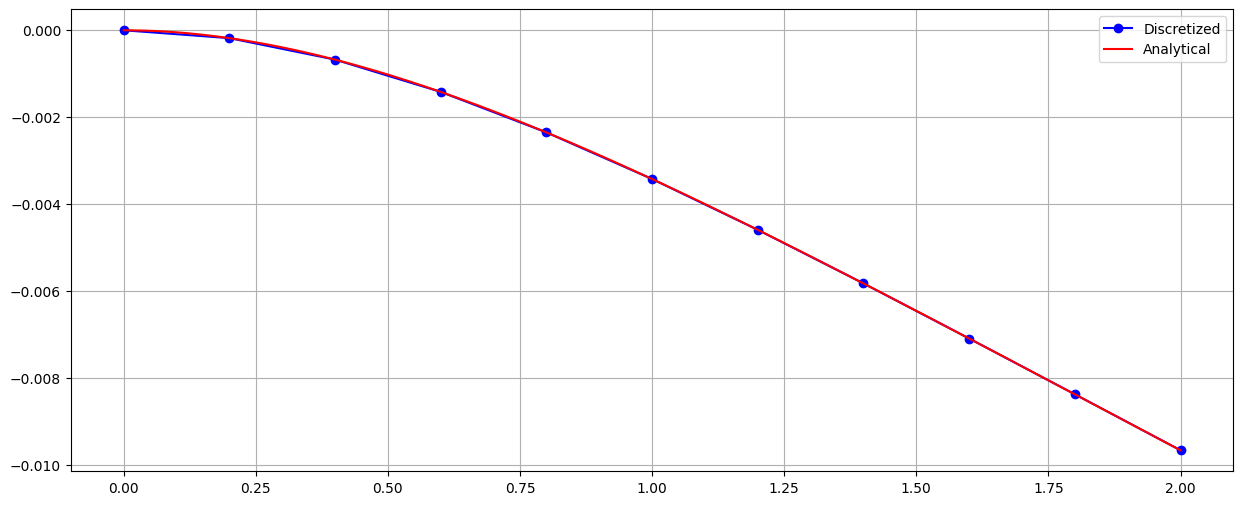

In [57]:
X1 = np.linspace(0, 2, 11)
Y1 = np.insert(y, 0, 0)

X2 = np.linspace(0, 2, 201)
yWithConstLoad = lambda x: f/(24*E*I)*x**2*(x**2-4*Length*x+6*Length**2)
Y2 = yWithConstLoad(X2)
print('Error on end:', np.abs(Y1[-1]-Y2[-1]))

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
line1, = plt.plot(X1, Y1, color='b', marker='o')
line2, = plt.plot(X2, Y2, color='r')
plt.legend((line1, line2), ['Discretized', 'Analytical'])
axes = plt.gca()
axes.grid()
plt.show()

3. 返回步骤1中的计算，对于 $n=10\cdot 2^k$，其中 $k=1,\dots,11$ .对于每个n在$x=L$时的误差制表，对于哪一个n这个误差最小?为什么这个误差在某一点后随着n增加?你可以再做一张关于A的条件数的表，该条件数对应一个关于n的函数，并有助于对最后一个问题的回答. 对于一个大的k实施这个步骤，你可能需要让MATLAB把矩阵A保存为一个稀疏矩阵以避免完全消耗内存，使用命令A=sparse(n,n)初始化A，就可以得到稀疏矩阵，其他操作和前面一样，我们将在下一节中更加详细地讨论稀疏矩阵.


In [120]:
# PA_LU_Factorization is quite slow, so we change to use 
Y = []
cond = []

for k in range(1, 12):
    print(f'k: {k}')
    n = 10*2**k
    A = MakeA(n, sparseOrNot=True)
    b = np.ones(n)*(f*(Length/n)**4/E/I)

    print('    spsolve...')
    y = sparse_linalg.spsolve(A, b)
    Y.append(y[-1])

    print('    Calculate condition number...')
    normOfA = sparse_linalg.norm(A, np.inf)
    normOfAInverse = sparse_linalg.norm(sparse_linalg.inv(A), np.inf)
    cond.append(normOfA*normOfAInverse)

print(cond)

# TODO
# SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
#   y = sparse_linalg.spsolve(A, b)
# SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
#   Ainv = spsolve(A, I)
# SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
#   Ainv = spsolve(A, I)

k: 1
    spsolve...
    Calculate condition number...
k: 2
    spsolve...
    Calculate condition number...
k: 3
    spsolve...
    Calculate condition number...
k: 4
    spsolve...
    Calculate condition number...
k: 5
    spsolve...
    Calculate condition number...
k: 6
    spsolve...
    Calculate condition number...


C:\Users\13988\AppData\Local\Temp\ipykernel_11176\2252788294.py:12: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  y = sparse_linalg.spsolve(A, b)
c:\Users\13988\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Ainv = spsolve(A, I)
c:\Users\13988\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


k: 7
    spsolve...
    Calculate condition number...
k: 8
    spsolve...
    Calculate condition number...
k: 9
    spsolve...
    Calculate condition number...
k: 10
    spsolve...
    Calculate condition number...
k: 11
    spsolve...
    Calculate condition number...
[558333.3333340492, 8933333.333328208, 142933333.3040416, 2286933336.605055, 36590932221.55964, 585454968794.5847, 9367285639550.219, 149871870982524.78, 2398118591913163.5, 3.8168156878572776e+16, 6.006570850054981e+17]


[1.23842e-14 5.53377e-15 1.97946e-12 1.38184e-11 2.93480e-10 5.85054e-10 6.91512e-09 2.95937e-07 3.83399e-07
 5.04039e-05 2.08271e-04]


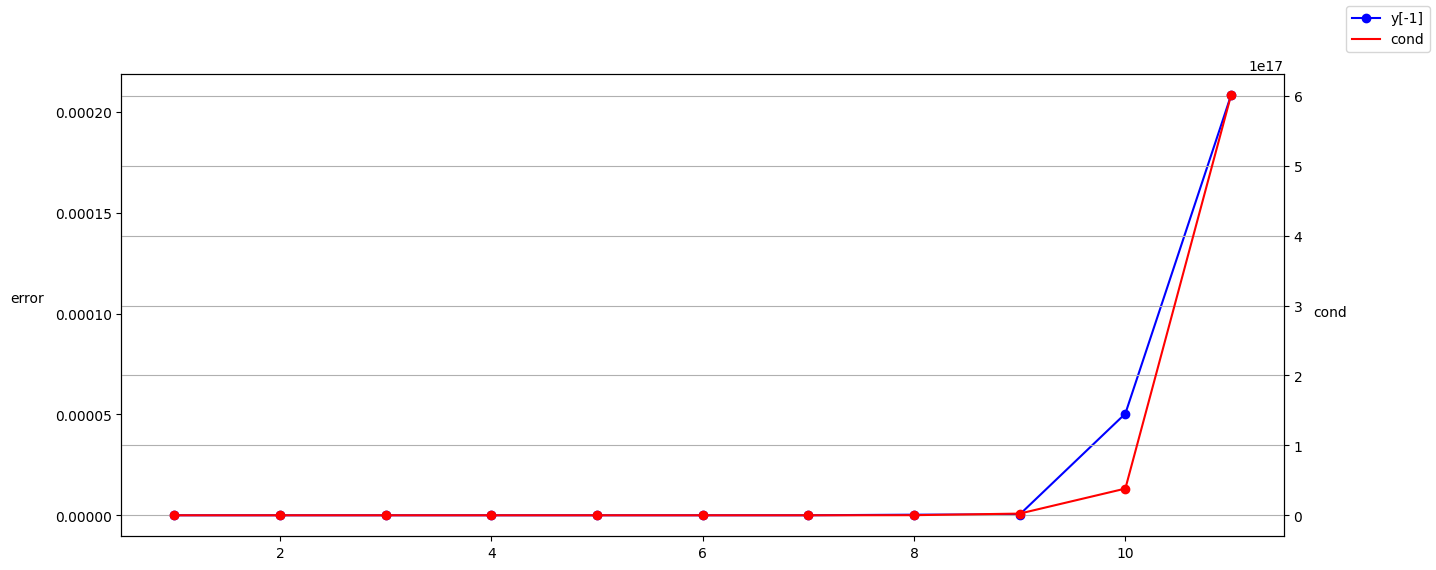

In [132]:
fig, axLeft = plt.subplots(figsize=(15, 6))
X = range(1, 12)
standardShift = -0.009659076923076925
error = np.abs(np.array(Y)-standardShift)
print(error)
# 在n=10*2**2=40时，误差最小

axLeft.plot(X, error, color='b', marker='o')
axLeft.set_ylabel('error', labelpad=20, rotation='horizontal')

axRight = axLeft.twinx()
axRight.plot(X, cond, color='r', marker='o')
axRight.set_ylabel('cond', labelpad=20, rotation='horizontal')

fig.legend((line1, line2), ['y[-1]', 'cond'])
axes = plt.gca()
axes.grid()
plt.show()


In [133]:
# 条件数的急剧增加导致微分方程的离散化技术失效？

4. 对横梁加上正弦压力，这意味着给受力项加上一个形如 $s(x)=pg\sin{\frac{\pi}{L}x}$ 的函数。证明解
$$
y(x)=\frac{f}{24EI}x^2(x^2-4Lx+6L^2)-\frac{pgL}{EI\pi}(\frac{L^3}{\pi^3}\sin\frac{\pi}{L}x-\frac{x^3}{6}+\frac{L}{2}x^2-\frac{L^2}{\pi^2}x)
$$
$\quad$ 满足欧拉-伯努利横梁方程以及钳制-自由边界条件.

$$
\begin{aligned}
Let \; z(x)&=\frac{f}{24EI}x^2(x^2-4Lx+6L^2) \\\\
y(0)&=0 \\\\
y'&=z'-\frac{pgL}{EI\pi}(\frac{L^2}{\pi^2}\cos{\frac\pi Lx}-\frac{x^2}{2}+Lx-\frac{L^2}{\pi^2}) \\
y'(0)&=z'(0)-\frac{pgL}{EI\pi}(\frac{L^2}{\pi^2}-\frac{L^2}{\pi^2})=0 \\\\
y''&=z''-\frac{pgL}{EI\pi}(-\frac{L}{\pi}\sin{\frac\pi Lx}-x+L) \\
y''(L)&=z''(L)-\frac{pgL}{EI\pi}(-L+L)=0 \\\\
y'''&=z'''-\frac{pgL}{EI\pi}(-\cos{\frac\pi Lx}-1) \\
y'''(L)&=z'''(L)-0=0 \\
\end{aligned}
$$

5. 重新运行第3步中对于正弦负载的计算. (确保包含了横臂自身的重量.) 设 $p=100kg/m$，同时画出你的计算结果和正确的解. 回答步骤3中的问题，并回答下面的问题: 在x=L点的误差和前面生成的$h^2$是否成比例? 你可以在log-log图上画出误差与h，来探求该问题. 条件数起作用了吗?

6. 现在移除正弦负载并在横梁上加上70kg跳水员，在横梁的最后20cm保持平衡. 你必须对 $f(x_i)$ 在单位长度加上力一g乘上 $70/0.2kg/m，1.8\leqslant z\leqslant 2$, 使用步骤5中找到的最优的n值，并再次求解问题. 画出图并找出跳水板在自由端的偏斜度.

7. 如果我们把跳水板的自由端也固定，就得到钳制-钳制横梁，两端的边界条件相同 $y(0)=y'(0)=y'(L)=0$. 它用于对下陷结构，例如桥梁，进行建模, 从有微小差异的均匀步长格点开始 $0=x_0<x_1<\dots<x_n><x_{n+1}$，其中 $h=x_i-x_{i-1}, i=1, \dots ,n$，找出具有n个方程n个未知变量的系统，用于确定 $y_1, \dots y_n$. (这和钳制-自由版本的模型类似，除了系数矩阵A的最后两行应该是前两行的反转. )对于正弦负载进行求解，并对于横梁中心 $x=L/2$ 回答步骤5中的问题。在正弦负载下的钳制-钳制横梁的精确解是
$$
y(x)=\frac{f}{24EI}x^2(L-x)^2-\frac{pgL}{\pi^4EI}(L^3\sin\frac{\pi}{L}x+\pi x(x-L))
$$


8. 更多探索的想法:如果跳水板的宽度加倍，跳水板的偏移该如何变化? 如果跳水板的厚度加倍这种变化会更多还是更少? (两个板的质量相同.)如果横截面是圆形或者环形，但是面积和矩形截面相同，最大偏移量会如何变化?( 面积惯性模量对于半径为r的圆形截面是 $I=\pi r^4/4$，对于内半径为 $r_1$ 外半径为 $r_2$ 的环形截面的面积惯性模量是 $I=π(r_2^4-r_1^4)/4$.) 找出对于I横梁的面积惯性模量. 不同材质的杨氏模量已知并已经被制表，例如，钢材的密度是 $7850kg/m^3$ ，它对应的杨氏模量大约是 $2X10^{11}$ 帕斯卡.   欧拉-伯努利是一个相对简单、经典的模型，更多最近的模型考虑更加奇异的扭曲，例如Timoshenko 横梁，其中横梁的截面与横梁的主轴可能不垂直.